# Assignment 4

#### Student ID: *Double click here to fill the Student ID*

#### Name: *Double click here to fill the name*

In [1]:
%pip install transformers datasets evaluate -qq
%pip install diffusers -qq
%pip install ftfy accelerate -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import json

# Tensorflow ≥2.8.0 is recommended
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow_datasets as tfds
import tensorflow_hub as hub

# Fintune CLIP, BERT, GPT
from transformers import pipeline
from transformers import AutoProcessor, TFAutoModelForZeroShotImageClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFAutoModelForCausalLM
from transformers import BertTokenizerFast, AutoModelForCausalLM
from transformers import TFAutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import create_optimizer
from transformers.keras_callbacks import KerasMetricCallback
from transformers.keras_callbacks import PushToHubCallback
from diffusers import StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler, PNDMScheduler
from datasets import load_dataset
import evaluate
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2023)
tf.random.set_seed(2023)

## Q1 Transfer learning on the dataset used by the CNN explainer

[CNN Explainer](https://poloclub.github.io/cnn-explainer/) is an interactive, open-source visualization tool designed to provide a comprehensive understanding of Convolutional Neural Networks (CNNs). In the last assignment, we tried to replicate the original experiment using TinyVGG by training the model from scratch. However, the results are not satisfactory. In this exercise, we will continue our journey and leverage transfer learning to improve the performance on the given test dataset. First, load the dataset using the following code (Feel free to change the code if you want to use `Pytorch` or other frameworks.):

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1zLUix-v08cUQViCaamjutM-FXn6eD1IL/view?usp=sharing
!unzip -qq data_hw3.zip

Downloading...
From: https://drive.google.com/uc?id=1zLUix-v08cUQViCaamjutM-FXn6eD1IL
To: /content/data_hw3.zip
100% 11.2M/11.2M [00:00<00:00, 50.1MB/s]


In [ ]:
training_images = 'class_10_train/'
vali_images = 'class_10_val/val_images/'
test_images = 'class_10_val/test_images/'

In [ ]:
train_dataset = image_dataset_from_directory(
    training_images,
    image_size=(64, 64),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    vali_images,
    image_size=(64, 64),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    test_images,
    image_size=(64, 64),
    batch_size=32)

Found 5000 files belonging to 10 classes.
Found 250 files belonging to 10 classes.
Found 250 files belonging to 10 classes.


#### (a) EfficientNet is a modern convnets obtained from [network architecture search](https://lilianweng.github.io/posts/2020-08-06-nas/). We will use it to perform transfer learning by using the following procedure: (10%)

1. First, add the callback to monitor the validation loss and save the best model base on the validation loss. 

2. Import the convolutional base of `EfficientNetV2S` (`efficientnet_v2_s`) and pre-trained weight from ImageNet. Try to freeze all the weights in the convolutional base. 

3. Add a dropout layer after the convolutional base (remember to flatten the output of the base before dropout) with a dropout rate set to 0.5, followed by a dense layer with softmax activation to classify the given 10 classes.

4. Train the model for 10 epochs using Adam optimizer with default learning rate. Finally, report the accuracy of the test set. Remember to reload the best model before the test.

Hint: Remember you may need different input preprocessing for each pre-train model. Checkout the documentation for that pretrain model first.

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(2023)
tf.random.set_seed(2023)
conv_base  = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    weights="imagenet",
    input_shape=(64, 64, 3),
    include_top=False,
    classes=10)
conv_base.trainable = False

82420632/82420632 [==============================] - 3s 0us/step


In [ ]:
inputs = tf.keras.Input(shape=(64, 64, 3))
# Apply input value scaling.
x = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)
x = conv_base(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 2, 2, 1280)       20331360  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 dropout (Dropout)           (None, 5120)              0         
                                                                 
 dense (Dense)               (None, 10)                51210     
                                                                 
Total params: 20,382,570
Trainable params: 51,210
Non-trainable params: 20,331,360
____________________________________________

In [ ]:
np.random.seed(2023)
tf.random.set_seed(2023)
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
    #lr_scheduler 
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
157/157 [==============================] - 29s 56ms/step - loss: 0.6518 - accuracy: 0.8024 - val_loss: 0.3364 - val_accuracy: 0.9040
Epoch 2/20
157/157 [==============================] - 6s 40ms/step - loss: 0.2950 - accuracy: 0.9112 - val_loss: 0.2955 - val_accuracy: 0.9080
Epoch 3/20
157/157 [==============================] - 4s 28ms/step - loss: 0.2315 - accuracy: 0.9266 - val_loss: 0.2728 - val_accuracy: 0.9040
Epoch 4/20
157/157 [==============================] - 5s 29ms/step - loss: 0.1942 - accuracy: 0.9432 - val_loss: 0.2614 - val_accuracy: 0.9160
Epoch 5/20
157/157 [==============================] - 6s 39ms/step - loss: 0.1653 - accuracy: 0.9504 - val_loss: 0.2516 - val_accuracy: 0.9080
Epoch 6/20
157/157 [==============================] - 6s 35ms/step - loss: 0.1426 - accuracy: 0.9546 - val_loss: 0.2548 - val_accuracy: 0.9080
Epoch 7/20
157/157 [==============================] - 7s 44ms/step - loss: 0.1330 - accuracy: 0.9612 - val_loss: 0.2660 - val_accuracy: 0.924

In [ ]:
model.load_weights("convnet_from_scratch.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

8/8 [==============================] - 0s 23ms/step - loss: 0.2717 - accuracy: 0.9000
Test accuracy: 0.900


#### (b) Looking at the training/validation loss, you can see that the model is overfitting. Try to add a data augmentation layer for the model in (a) as follows: (10%)

* Applies random horizontal flipping 
* Rotates the input images by a random value in the range `[–36 degrees, +36 degrees]`)
* Zooms in or out of the image by a random factor in the range `[-20%, +20%]`
* Randomly choose a location to crop images down to a target size `[56, 56]`
* Randomly adjust the contrast of images so that the resulting images are `[0.85, 1.15]` brighter or darker than the original one.

In addition, unfreeze the last three layers of the convolutional base (i.e., We will fine-tune the last three layers and the classification head). Fit your model for enough epochs (40, for instance). Finally, report the accuracy of the test set. Remember to reload the best model before the test.

Hint: You can find out how to apply the data augmentation in the previous lab. Notice that to make the shape compatible, you need to construct the convolutional base with a different size that meets the output of the data augmentation layer.

In [ ]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomCrop(56,56),
        tf.keras.layers.RandomContrast(0.15)
    ]
)

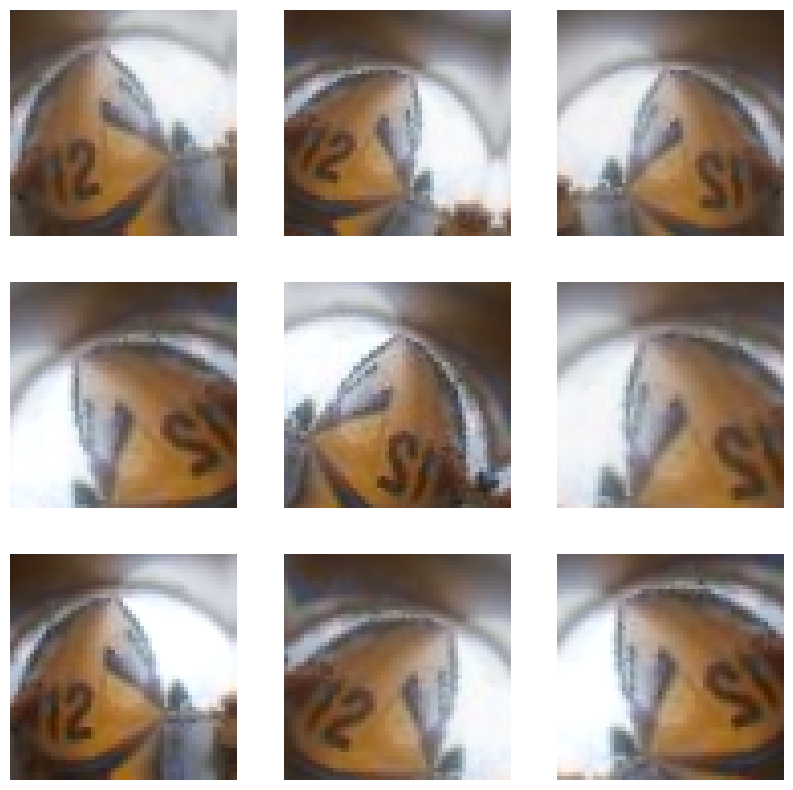

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1): #Sample 1 batch from the dataset
    for i in range(9):
      # During inference time, the output will be identical to input. 
      # Call the layer with training=True to flip the input.
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(2023)
tf.random.set_seed(2023)
conv_base  = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    weights="imagenet",
    input_shape=(56, 56, 3),
    include_top=False,
    classes=10)
conv_base.trainable = False

inputs = tf.keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
# Apply input value scaling.
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)
x = conv_base(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
conv_base.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 56, 56, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 56, 56, 3)    0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 28, 28, 24)   648         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 28, 28, 24)   96          ['stem_conv[0][0]']              
                                                                                   

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-3]:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 56, 56, 3)         0         
                                                                 
 efficientnetv2-s (Functiona  (None, 2, 2, 1280)       20331360  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 dropout (Dropout)           (None, 5120)              0         
                                                                 
 output (Dense)              (None, 10)                51210     
                                                             

In [ ]:
np.random.seed(2023)
tf.random.set_seed(2023)
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch3.keras",
        save_best_only=True,
        monitor="val_loss")
    #lr_scheduler 
]
history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/40
157/157 [==============================] - 38s 87ms/step - loss: 0.7765 - accuracy: 0.7502 - val_loss: 0.3743 - val_accuracy: 0.8760
Epoch 2/40
157/157 [==============================] - 10s 64ms/step - loss: 0.4431 - accuracy: 0.8598 - val_loss: 0.2699 - val_accuracy: 0.9080
Epoch 3/40
157/157 [==============================] - 6s 38ms/step - loss: 0.4154 - accuracy: 0.8708 - val_loss: 0.2778 - val_accuracy: 0.9040
Epoch 4/40
157/157 [==============================] - 10s 65ms/step - loss: 0.3793 - accuracy: 0.8838 - val_loss: 0.3015 - val_accuracy: 0.8960
Epoch 5/40
157/157 [==============================] - 9s 59ms/step - loss: 0.3463 - accuracy: 0.8970 - val_loss: 0.2642 - val_accuracy: 0.9240
Epoch 6/40
157/157 [==============================] - 6s 38ms/step - loss: 0.3354 - accuracy: 0.8914 - val_loss: 0.2608 - val_accuracy: 0.9240
Epoch 7/40
157/157 [==============================] - 5s 30ms/step - loss: 0.2944 - accuracy: 0.9060 - val_loss: 0.2685 - val_accuracy: 0.9

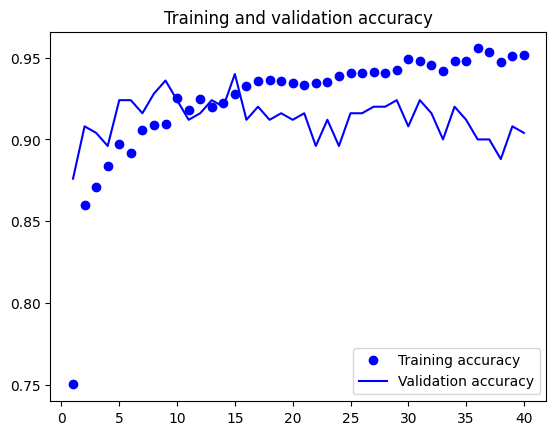

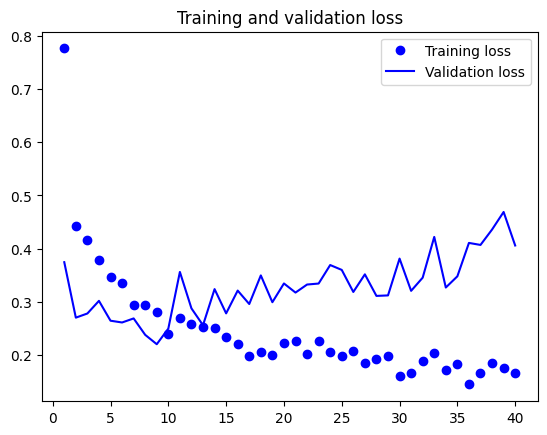

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model.load_weights("convnet_from_scratch3.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

8/8 [==============================] - 0s 25ms/step - loss: 0.3546 - accuracy: 0.9080
Test accuracy: 0.908


#### (c) `CLIP` is a foundation model that contains both text and image encoder. The multimodal nature makes it possible to conduct zero-shot classification. In this problem, we will leverage it to perform the classification. (15%)

1. Firstly, try to load the model and processor with checkpoint [`openai/clip-vit-large-patch14`](https://huggingface.co/openai/clip-vit-large-patch14) from hugging face. 

2. Secondly, use the following mapping to generate the candidate text labels: 
```
{'n01882714': 'koala', 
 'n02165456': 'ladybug', 
 'n02509815': 'lesser panda', 
 'n03662601': 'lifeboat', 
 'n04146614': 'school bus', 
 'n04285008': 'sports car', 
 'n07720875': 'bell pepper', 
 'n07747607': 'orange', 
 'n07873807': 'pizza', 
 'n07920052': 'espresso'}
```

3. Thirdly, perform zero-shot 10 class classification using the processor and the `CLIP` model on the test dataset. 

4. Finally, calculate the accuracy on the test dataset.

Hint: If you are using `image_dataset_from_directory` function, it will assign labels to images based on their directory names. The labels are integer indices of the class names sorted alphabetically (i.e., 'n01882714'-> 0, 'n02165456'-> 1 ...). In addition, refer to our lab to see how to perform zero-shot classification. Finally, remember that you can extract the image data and labels from the test set into `X` and `y` `NumPy` arrays.

In [ ]:
checkpoint = "openai/clip-vit-large-patch14"

model = TFAutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-large-patch14.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
# Load the data from the JSON file
with open('class_dict.json', 'r') as f:
    data = json.load(f)

# Create a new dictionary with only the mappings and split the class name at the comma
mapping = {key: value['class'].split(',')[0] for key, value in data.items()}

# Sort the dictionary by keys
sorted_mapping = dict(sorted(mapping.items()))

# Print the sorted mapping
print(sorted_mapping)

{'n01882714': 'koala', 'n02165456': 'ladybug', 'n02509815': 'lesser panda', 'n03662601': 'lifeboat', 'n04146614': 'school bus', 'n04285008': 'sports car', 'n07720875': 'bell pepper', 'n07747607': 'orange', 'n07873807': 'pizza', 'n07920052': 'espresso'}


In [ ]:
images = []
labels = []

for image_batch, label_batch in test_dataset.unbatch().as_numpy_iterator():
    images.append(image_batch)
    labels.append(label_batch)

In [ ]:
list(sorted_mapping.values())

['koala',
 'ladybug',
 'lesser panda',
 'lifeboat',
 'school bus',
 'sports car',
 'bell pepper',
 'orange',
 'pizza',
 'espresso']

In [ ]:
candidate_labels = list(sorted_mapping.values())

In [ ]:
inputs = processor(images=images, text=candidate_labels, return_tensors="tf", padding=True)

In [ ]:
outputs = model(**inputs)

# Assuming that 'outputs' is a dictionary and 'logits_per_image' is a key that returns a batch of logits
logits = outputs['logits_per_image']

In [ ]:
probs = tf.nn.softmax(logits, axis=-1).numpy()
predicted_class = tf.math.argmax(probs, axis=-1)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(predicted_class, labels)

0.964

#### (d) [Stable diffusion](https://huggingface.co/blog/stable_diffusion) is a text-to-image model that can generate high-quality images using a diffusion model. Try to design a prompt (e.g.: "a photo of ...") to generate three realistic photos that belong to one of the given 10 classes in the CNN explainer (i.e.:koala, ladybug....) using `diffuser` or `KerasCV`. Finally, plot the above three generated images. (15%)

In [3]:
def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

In [4]:
import torch
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe = pipe.to("cuda") # let's move the pipeline to GPU to have faster inference.

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [5]:
num_images = 3
prompt = ["A zoomed out photograph of a cool looking koala"] * num_images
images = pipe(prompt).images

# If you're in a google colab you can directly display it with 
images

  0%|          | 0/50 [00:00<?, ?it/s]

[<PIL.Image.Image image mode=RGB size=512x512 at 0x7FCB9DE539D0>,
 <PIL.Image.Image image mode=RGB size=512x512 at 0x7FCB9DE52A40>,
 <PIL.Image.Image image mode=RGB size=512x512 at 0x7FCB9DE53640>]

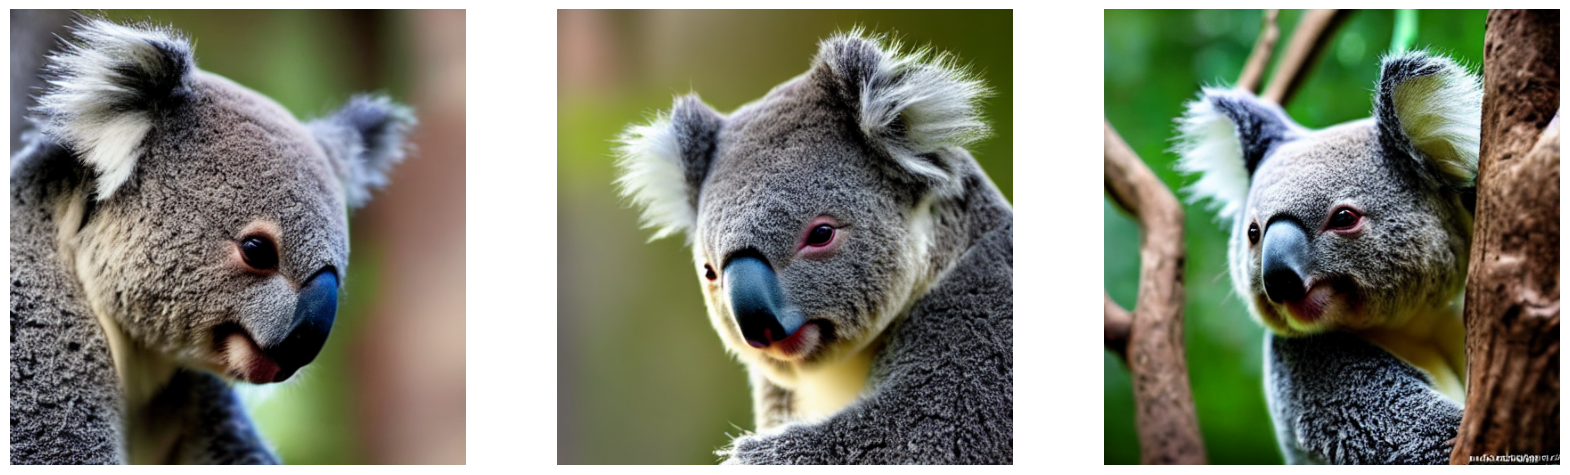

In [6]:
plot_images(images)

In [7]:
print(torch.cuda.is_available())

True


In [ ]:
#del pipe
import gc
gc.collect()
torch.cuda.empty_cache()

#### (e) Firstly, resize the three images you generate in (e) into $64 \times 64$ pixels. Secondly, use the best model you found in (a)-(b) and the `CLIP` model in (c) to perform inference on these three downsample images. Are the results from the two models correct on all three images? (10%)

Hint: You can use PIL/OpenCV/Skimage or even NumPy to resize the images.

In [ ]:
images2 = []
for im1 in images:
    images2.append(im1.resize((64,64)))

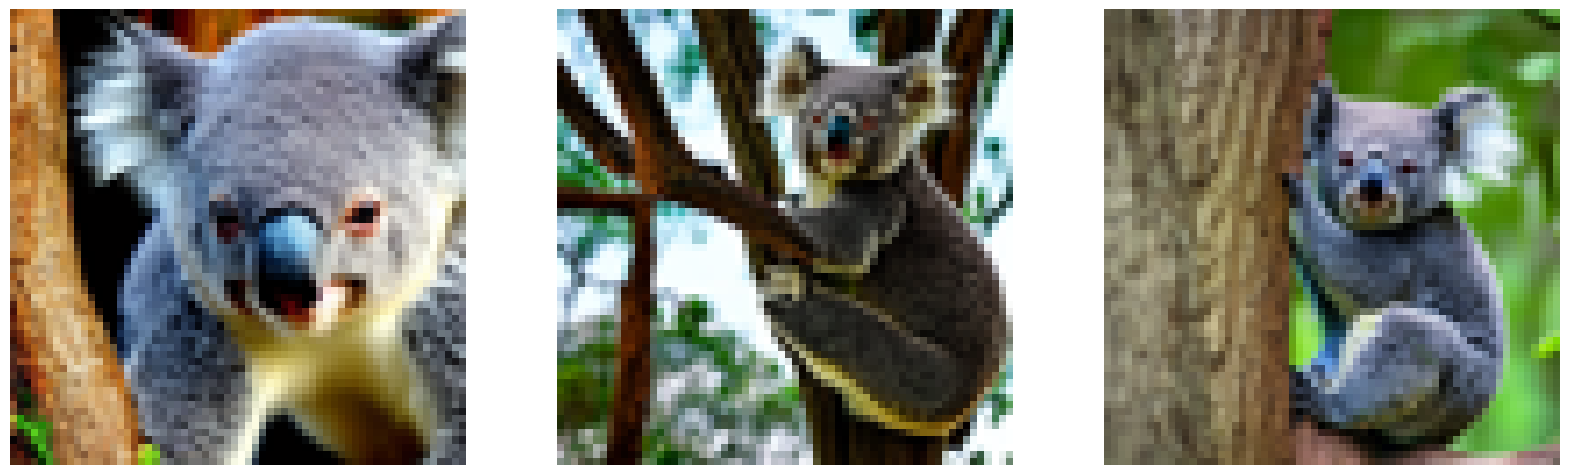

In [ ]:
plot_images(images2)

In [ ]:
inputs = processor(images=images2, text=candidate_labels, return_tensors="tf", padding=True)
outputs = model(**inputs)

# Assuming that 'outputs' is a dictionary and 'logits_per_image' is a key that returns a batch of logits
logits = outputs['logits_per_image']
probs = tf.nn.softmax(logits, axis=-1).numpy()
predicted_class = tf.math.argmax(probs, axis=-1)
predicted_class

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 0])>

In [ ]:
numpy_images = [np.array(image) for image in images2]
# Convert list of numpy arrays to a tensor
tensor_images = tf.convert_to_tensor(numpy_images)

In [ ]:
tensor_images.shape

TensorShape([3, 64, 64, 3])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 56, 56, 3)         0         
                                                                 
 efficientnetv2-b0 (Function  (None, 2, 2, 1280)       5919312   
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 dropout (Dropout)           (None, 5120)              0         
                                                                 
 output (Dense)              (None, 10)                51210     
                                                             

In [ ]:
model.load_weights("convnet_from_scratch3.keras")

In [ ]:
probs = model.predict(tensor_images)
tf.math.argmax(probs, axis=-1)

1/1 [==============================] - 0s 53ms/step


<tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 0])>

Both model correcly classifiy the three images.

## Q2 Analyze sentiment dataset using different models

[Sentiment analysis](https://demo.allennlp.org/sentiment-analysis/glove-sentiment-analysis) is a subfield of natural language processing (NLP) that involves determining the emotional tone behind words. Its purpose is to understand the attitudes, opinions, and emotions of a speaker or writer with respect to some topic or the overall contextual polarity of a document. In this problem, we will use the dataset that comes from three different websites/fields:
`imdb.com`, `amazon.com` and `yelp.com` and we will classify each sentence as positive(1) or negative(0). Firstly, execute the following code cell to import the dataset and organize them into a dataset (Feel free to change the code if you would like to use `Pytorch` or other frameworks.):

In [ ]:
!unzip -qq /content/sentiment-data.zip

Archive:  /content/sentiment-labelled-sentences-data-set.zip
  inflating: sentiment labelled sentences/amazon_cells_labelled.csv  
  inflating: sentiment labelled sentences/amazon_cells_labelled.txt  
  inflating: sentiment labelled sentences/imdb_labelled.csv  
  inflating: sentiment labelled sentences/imdb_labelled.txt  
  inflating: sentiment labelled sentences/readme.txt  
  inflating: sentiment labelled sentences/sentiment labelled sentences/amazon_cells_labelled.csv  
  inflating: sentiment labelled sentences/sentiment labelled sentences/amazon_cells_labelled.txt  
  inflating: sentiment labelled sentences/sentiment labelled sentences/imdb_labelled.csv  
  inflating: sentiment labelled sentences/sentiment labelled sentences/imdb_labelled.txt  
  inflating: sentiment labelled sentences/sentiment labelled sentences/readme.txt  
  inflating: sentiment labelled sentences/sentiment labelled sentences/yelp_labelled.csv  
  inflating: sentiment labelled sentences/sentiment labelled sent

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

filepath_dict = {'yelp':   'sentiment labelled sentences/sentiment labelled sentences/yelp_labelled.txt',
                 'amazon': 'sentiment labelled sentences/sentiment labelled sentences/amazon_cells_labelled.txt',
                 'imdb':   'sentiment labelled sentences/sentiment labelled sentences/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source
    df_list.append(df)

df = pd.concat(df_list)

sentences = df['sentence'].to_numpy()
y = df['label'].to_numpy()

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=2023)
train_ds = tf.data.Dataset.from_tensor_slices((sentences_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((sentences_test, y_test))

train_ds = train_ds.shuffle(3000).batch(32)
val_ds = val_ds.batch(32)
text_only_train_ds = train_ds.map(lambda x, y: x)

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp
...,...,...,...
743,I just got bored watching Jessice Lange take h...,0,imdb
744,"Unfortunately, any virtue in this film's produ...",0,imdb
745,"In a word, it is embarrassing.",0,imdb
746,Exceptionally bad!,0,imdb


#### (a) Bag-of-word model is a popular approach in NLP to represent text data and we will try this model first. (15%)

1. Firstly, try to build the representation of the input text using bigram and TF-IDF encoding. Set the maximum token to 10,000 when performing vectorization so that we get a vector of 10,000 dimensions for each sample. 

2. Secondly, build a simple MLP model as follows: 

|        | Type                | Maps    | Activation | Notice|
|--------|---------------------|---------|------------|------------|
| Output | Fully connected     |       | Sigmoid    | Binary classification|
| D2     | Dropout |         |            |with dropout rate set to 0.75|
| D1     | Fully connected          | 16      | ReLu       |16 neurons|
| In     | Input               |  |            |Input is 10,000 dimension|


3. Add the callback to monitor the validation loss and save the best model base on the **validation accuracy**. Fit the model with `Adam` optimizer for 10 epochs with the default learning rate. 

4. Finally, report the best validation accuracy.

Hint: Refer to our lab to see how to use `TextVectorization` layer in `Keras` to vectorize the training and validation set. If you are using `Pytorch` you may find `torchtext` and `TfidfVectorizer` from `sklearn` useful.

In [ ]:
text_vectorization = tf.keras.layers.TextVectorization(
    ngrams=2,
    max_tokens=10000,
    output_mode="tf_idf",
)

text_vectorization.adapt(text_only_train_ds)

In [ ]:
tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(2023)
tf.random.set_seed(2023)
inputs = tf.keras.Input(shape=(10000,))
x = tf.keras.layers.Dense(16, activation="relu")(inputs)
x = tf.keras.layers.Dropout(0.75)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()  

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="bow.keras",
        save_best_only=True,
        monitor="val_accuracy")
]
model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense (Dense)               (None, 16)                160016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(tfidf_2gram_train_ds.cache(),
          validation_data=tfidf_2gram_val_ds.cache(),
          epochs=10, callbacks=callbacks)

Epoch 1/10
65/65 [==============================] - 3s 14ms/step - loss: 0.7525 - accuracy: 0.5337 - val_loss: 0.6631 - val_accuracy: 0.6667
Epoch 2/10
65/65 [==============================] - 0s 5ms/step - loss: 0.6300 - accuracy: 0.6429 - val_loss: 0.6136 - val_accuracy: 0.7569
Epoch 3/10
65/65 [==============================] - 0s 5ms/step - loss: 0.5591 - accuracy: 0.7259 - val_loss: 0.5930 - val_accuracy: 0.7817
Epoch 4/10
65/65 [==============================] - 0s 5ms/step - loss: 0.4967 - accuracy: 0.7700 - val_loss: 0.5857 - val_accuracy: 0.7948
Epoch 5/10
65/65 [==============================] - 0s 5ms/step - loss: 0.4385 - accuracy: 0.8064 - val_loss: 0.5613 - val_accuracy: 0.8122
Epoch 6/10
65/65 [==============================] - 0s 6ms/step - loss: 0.3758 - accuracy: 0.8510 - val_loss: 0.5037 - val_accuracy: 0.8282
Epoch 7/10
65/65 [==============================] - 0s 5ms/step - loss: 0.3610 - accuracy: 0.8515 - val_loss: 0.5775 - val_accuracy: 0.7962
Epoch 8/10
65/65 [=

In [ ]:
model.load_weights("bow.keras")
test_loss, test_acc = model.evaluate(tfidf_2gram_val_ds)
print(f"Validation accuracy: {test_acc:.3f}")

22/22 [==============================] - 0s 3ms/step - loss: 0.5074 - accuracy: 0.8326
Validation accuracy: 0.833


#### (b) Now, we will go with the sequence model. (15%)

1. Firstly, set the maximum length and maximum token to 200 and 10,000 when vectorizing the text, respectively. 

2. Secondly, build an RNN as follows: 

|        | Type                | Maps    | Activation | Notice|
|--------|---------------------|---------|------------|------------|
| Output | Fully connected     |       | Sigmoid    | Binary classification|
| D1     | Dropout |         |            |with dropout rate set to 0.75|
| R1     | Bidirectional RNN  with GRU cell        | 16      |        |Bidirectional RNN layer with 16 GRU cells|
| E1     | Embedding         |       |        | Output of embedding is set to 64 dimensions and remember to mask the padded zeros |
| In     | Input               |  |            |Input is truncated to 200 words with 10,000 dimensions |

3. Add the callback to monitor the validation loss and save the best model base on the **validation accuracy**. Fit the model with `Adam` optimizer for 10 epochs with the default learning rate. 

4. Finally, report the best validation accuracy.

Hint: Refer to our lab to see how to use `TextVectorization` layer in `Keras` to vectorize the training and validation set. If you are using `Pytorch`, you may find `torchtext` useful.

In [ ]:
max_length = 200
max_tokens = 10000
text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(2023)
tf.random.set_seed(2023)
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.keras.layers.Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True)(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16))(embedded)
x = tf.keras.layers.Dropout(0.75)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, 32)               7872      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 647,905
Trainable params: 647,905
Non-trainable params: 0
_______________________________________________________

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="gru.keras",
        save_best_only=True,
        monitor="val_accuracy")
    #lr_scheduler 
]
model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

Epoch 1/10
65/65 [==============================] - 28s 195ms/step - loss: 0.6884 - accuracy: 0.5594 - val_loss: 0.6807 - val_accuracy: 0.6725
Epoch 2/10
65/65 [==============================] - 10s 152ms/step - loss: 0.6415 - accuracy: 0.7351 - val_loss: 0.5936 - val_accuracy: 0.7715
Epoch 3/10
65/65 [==============================] - 5s 71ms/step - loss: 0.4137 - accuracy: 0.8520 - val_loss: 0.4231 - val_accuracy: 0.8151
Epoch 4/10
65/65 [==============================] - 5s 78ms/step - loss: 0.1698 - accuracy: 0.9481 - val_loss: 0.4790 - val_accuracy: 0.8268
Epoch 5/10
65/65 [==============================] - 2s 36ms/step - loss: 0.0922 - accuracy: 0.9816 - val_loss: 0.5628 - val_accuracy: 0.8180
Epoch 6/10
65/65 [==============================] - 3s 41ms/step - loss: 0.0566 - accuracy: 0.9879 - val_loss: 0.6344 - val_accuracy: 0.8311
Epoch 7/10
65/65 [==============================] - 3s 41ms/step - loss: 0.0347 - accuracy: 0.9918 - val_loss: 0.7447 - val_accuracy: 0.8122
Epoch 8/1

In [ ]:
model.load_weights("gru.keras")
test_loss, test_acc = model.evaluate(int_val_ds)
print(f"Validation accuracy: {test_acc:.3f}")

22/22 [==============================] - 0s 6ms/step - loss: 0.6344 - accuracy: 0.8311
Validation accuracy: 0.831


#### (c) There is a [rule of thumb](https://developers.google.com/machine-learning/guides/text-classification/step-2-5#algorithm_for_data_preparation_and_model_building) that you should pay close attention to the **ratio between the number of samples in your training data and the mean number of words per sample** when approaching a new text classification task. If that ratio is smaller or less than 1,500, the bag-of-bigrams model will perform better. If that ratio exceeds 1,500, you should go with a sequence model. In other words, sequence models work best when lots of training data are available and each sample is relatively short. (10%) 

Try to plot the Histogram of the number of words per sample for the training dataset and calculate the ratio described above. Finally, compare the accuracy you get using bag-of-bigrams in (a) and the results you get in (b). Make some comments on the rule of thumb.

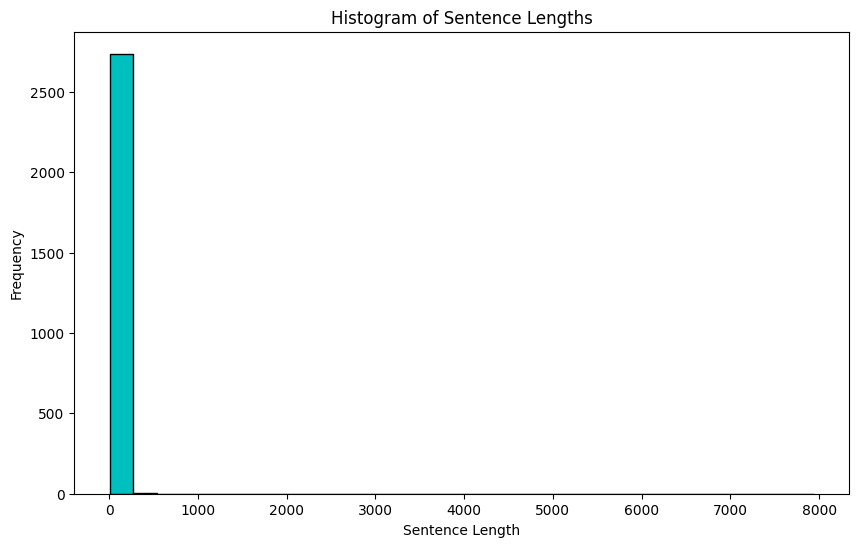

In [ ]:
sentence_lengths = df['sentence'].str.len()

plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=30, color='c', edgecolor='black')
plt.title('Histogram of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
sentence_lengths.mean(), sentence_lengths.max()

(71.52838427947599, 7944)

In [ ]:
sentence_lengths = df['sentence'].str.len()
ratio = len(df['sentence'])/sentence_lengths.mean()
ratio 

38.41831501831501

The peformance is quiete close, which may due to the fact that the training data is little. However, the bag-of-word model is still slightly better if we run the experiment several times.

#### (d) GPT is a powerful pretrained foundation model that can generate text. (10%)

1. Firstly, try to load the model and tokenizer with checkpoint [`gpt2-xl`](https://huggingface.co/gpt2-xl) from the hugging face. 

2. Secondly, design a prompt and use the `generate()` method to generate 200 tokens that represent a positive review (For instance, you can feed the text "The movie is great" to the model and let it generate 200 tokens). 

3. Finally, feed the review to the best model you found in (a) and (b). Does the model predict the review as positive? 

Hint: You can try to tune the `do_sample`, `top_k`, `num_beams` or  `temperature` in the `generate()` function so that the generated text is more convincing. Again, refer to our lab for a brief introduction.

In [ ]:
# Select device
device = "GPU:0" if tf.config.list_physical_devices('GPU') else "CPU"

# Select model and tokenizer
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForCausalLM.from_pretrained(model_name)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2-xl.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [ ]:
input_txt = "This restuarent is great"
input_ids = tokenizer(input_txt, return_tensors="tf")["input_ids"]
iterations = []
n_steps = 200

output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=True, top_k=20)
print("========Generated Text==========")
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


========Generated Text==========
This restuarent is great to work with. I would definitely use them again and again. I had to go back for a second day because they were running out of space for my dog." —Kelvin K., New York

Best Dog Grooming Products

"Best grooming products I have ever used. When I go in I will bring my own brushes so I can change them in there. The staff knows what they're doing and is very professional. I will absolutely recommend them to people." —Garrett, New York

"I have had great experience with all the products here. When you go to the grooming, they have a huge area to wash and clean off your dog after the service and all of the staff are super nice, courteous, and friendly." —Giovanni V., New York

"I can't say enough great things about this place. The staff is professional, courteous, courteous, courteous, and friendly. I have had


In [ ]:
text_vectorization = tf.keras.layers.TextVectorization(
    ngrams=2,
    max_tokens=10000,
    output_mode="tf_idf",
)

text_vectorization.adapt(text_only_train_ds)

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([747.4965  ,   7.182665,   8.464821, ...,   0.      ,   0.      ,
         0.      ], dtype=float32)>

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(2023)
tf.random.set_seed(2023)
inputs = tf.keras.Input(shape=(10000,))
x = tf.keras.layers.Dense(16, activation="relu")(inputs)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()  

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="bow.keras",
        save_best_only=True,
        monitor="val_loss")
]
model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense (Dense)               (None, 16)                160016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sen = text_vectorization(tokenizer.decode(output[0]))
sen2 = tf.reshape(sen, (-1,10000))

In [ ]:
sen2

<tf.Tensor: shape=(1, 10000), dtype=float32, numpy=
array([[747.4965  ,   7.182665,   8.464821, ...,   0.      ,   0.      ,
          0.      ]], dtype=float32)>

In [ ]:
model.load_weights("bow.keras")
model.predict(sen2)

1/1 [==============================] - 0s 92ms/step


array([[0.99999976]], dtype=float32)

The generated comment is positive.